In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import perceval as pcvl
from numpy.random import default_rng

import torch
from torch.autograd import Variable
from torch.utils.data import RandomSampler
import torchvision.transforms as transforms

from skimage.metrics import structural_similarity as ssim

import sys; sys.path.insert(0, '..')
from models.qgan import QGAN
from models.generators import ClassicalGenerator as Generator
from helpers.data.digits import DigitsDataset


In [2]:
path = "./ideal/"

In [3]:
def get_metrics(real, fake):
    count = len(real)
    diversity = 0
    similarity = 0
    for i in range(count):
        for j in range(i + 1, count):
            similarity += ssim(real[i], fake[j], data_range=1.0)
            diversity += ssim(fake[i], fake[j], data_range=1.0)
    similarity /= count * (count - 1) / 2
    diversity /= count * (count - 1) / 2

    return similarity, 1 - diversity

In [4]:
def get_classical_images(count):
    class_gen = Generator()
    class_gen.load_state_dict(torch.load("../models/classical_generator.dict"))
    fakes = class_gen(Variable(torch.FloatTensor(np.random.normal(0, 1, (count, 2))))).detach().numpy()

    # normalize
    mins = np.repeat(np.min(fakes, axis = 1).reshape(-1, 1), 64, axis=1)
    maxes = np.repeat(np.max(fakes, axis = 1).reshape(-1, 1), 64, axis=1)
    fakes = (fakes -  mins) / (maxes - mins)

    return fakes

In [14]:
def get_fake_images(params_runs, config, count):
    images = []
    final_results = []
    num_results = count
    
    qgan = QGAN(
        8,
        config["gen_count"],
        config["arch"],
        pcvl.BasicState(config["input_state"]),
        config["noise_dim"],
        4,
        config["pnr"],
        lossy = False
    )
    
    for params in params_runs:
        qgan.G.update_var_params(params[-1])
        final_results.append(qgan.G.generate(np.random.normal(0, 2 * np.pi, (num_results, config["noise_dim"]))).numpy())

    rng = default_rng()
    final_results = np.swapaxes(final_results, 0, 1)
    
    for data in np.array(final_results):
        numbers = rng.choice(10, size=5, replace=False)
        image = data[numbers, :].mean(axis = 0)
        images.append(image)

    return np.array(images)

In [16]:
qsims = []
qdivs = []

for config_num in range(28):
    dataset = DigitsDataset(
        csv_file="../helpers/data/optdigits_csv.csv",
        label=config_num if path == "./digits/" else 0,
        transform=transforms.Compose([transforms.ToTensor()]),
    )
    sampler = RandomSampler(dataset, replacement=True, num_samples=10)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1, drop_last=True, sampler=sampler
    )
    count = len(dataset)

    reals = np.array(dataloader.dataset.df.iloc[:, :-1]) / 16

    if config_num == 0:
        c_sim, c_div = get_metrics(reals, get_classical_images(count))

        print("Similarity", c_sim)
        print("Diversity", c_div)


    config_path = path + "config_" + str(config_num)
    with open(config_path + "/config.json") as c:
        config = json.load(c)


    print("Config", config_num)
    print(config)

    loss_runs = []
    fake_runs = []
    params_runs = []
    for run_num in range(1, 11):
        full_path = path + "config_" + str(config_num) + "/run_" + str(run_num)

        loss_runs.append(np.loadtxt(full_path + "/loss_progress.csv", delimiter=","))
        fake_runs.append(np.loadtxt(full_path + "/fake_progress.csv", delimiter=","))
        params_runs.append(
            np.loadtxt(full_path + "/G_params_progress.csv", delimiter=",")
        )


    q_sim, q_div = get_metrics(reals, get_fake_images(np.array(params_runs), config, count))
    
    print("Similarity", q_sim)
    print("Diversity", q_div)

    qsims.append(q_sim)
    qdivs.append(q_div)


Similarity 0.7440159237869912
Diversity 0.08878214573638876
Config 0
{'input_state': [0, 1, 0, 1, 0], 'gen_count': 4, 'pnr': False, 'noise_dim': 1, 'arch': ['var', 'enc[2]', 'var']}
Similarity 0.5472635784774779
Diversity 0.24432686844999285
Config 1
{'input_state': [0, 1, 0, 1, 0], 'gen_count': 4, 'pnr': False, 'noise_dim': 1, 'arch': ['var', 'var', 'enc[2]', 'var', 'var']}
Similarity 0.7268648224618859
Diversity 0.11028815310557416
Config 2
{'input_state': [0, 1, 0, 1, 0], 'gen_count': 4, 'pnr': False, 'noise_dim': 2, 'arch': ['var', 'enc[1]', 'var', 'enc[3]', 'var']}
Similarity 0.6050719323324091
Diversity 0.2273811242519388
Config 3
{'input_state': [0, 1, 0, 1, 0], 'gen_count': 4, 'pnr': False, 'noise_dim': 2, 'arch': ['var', 'var', 'enc[1]', 'var', 'var', 'enc[3]', 'var', 'var']}
Similarity 0.5772017396060753
Diversity 0.280645233519096
Config 4
{'input_state': [0, 1, 0, 1, 0], 'gen_count': 4, 'pnr': False, 'noise_dim': 3, 'arch': ['var', 'enc[0]', 'var', 'enc[2]', 'var', 'enc[4]'

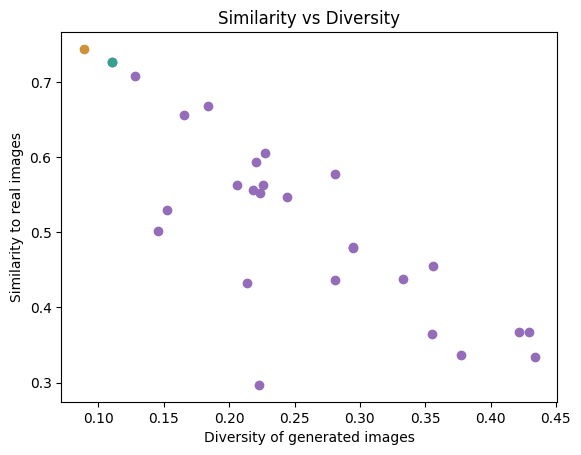

In [18]:
plt.scatter([qdiv for qdiv in qdivs if qdiv < 0.5], [qsim for i, qsim in enumerate(qsims) if qdivs[i] < 0.5], color="#946cba")
plt.scatter(qdivs[1], qsims[1], color = "#37a191")
plt.scatter(c_div, c_sim, color = "#ce9239")


plt.title("Similarity vs Diversity")
plt.xlabel("Diversity of generated images")
plt.ylabel("Similarity to real images")

plt.show()